# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

# Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')



/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
#pwd
current_file = os.path.abspath(os.path.dirname(__file__))
print(current_file)

NameError: name 'os' is not defined

In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias.shape
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
customers.shape
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [5]:
# import features from DIAS Attributes - Values 2017.xlsx

dias_attributes = pd.read_excel('DIAS Attributes-UpdatedValues2017.xlsx')
dias_attributes.head()
dias_attributes = dias_attributes.drop(['Unnamed: 0'], axis=1)


In [6]:
# Get all attributes' unknown values into a dictionary  

def get_attributes_with_unknown_value(df):
    result = {}
    
    for index, row in df.iterrows():
        values = []
        if type(row.Value) != str:
            values.append(row.Value)
            result[row.Attribute] = values
        else:
            values = [int(x.strip()) for x in row.Value.split(',')]
            result[row.Attribute] = values
    
    return result

In [7]:
attributes_df = pd.DataFrame(dias_attributes, columns = ['Attribute', 'Description', 'Value', 'Meaning'])

attributes_df = attributes_df[attributes_df['Meaning'].notna()]

attributes_df = attributes_df[attributes_df['Meaning'].str.contains('known')]
print(attributes_df.shape) ## todo should be 294

attribute_unknown_val_dict = get_attributes_with_unknown_value(attributes_df)
attribute_unknown_val_dict

(294, 4)


{'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ALTER_HH': [0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_BANKEN_ANZ_12': [0],
 'D19_BANKEN_ANZ_24': [0],
 'D19_BANKEN_DATUM': [10],
 'D19_BANKEN_DIREKT_RZ': [0],
 'D19_BANKEN_GROSS_RZ': [0],
 'D19_BANKEN_LOKAL_RZ': [0],
 'D19_BANKEN_OFFLINE_DATUM': [10],
 'D19_BANKEN_ONLINE_DATUM': [10],
 'D19_BANKEN_REST_RZ': [0],
 'D19_BEKLEIDUNG_GEH_RZ': [0],
 'D19_BEKLEIDUNG_REST_RZ': [0],
 'D19_BILDUNG_RZ': [0],
 'D19_BIO_OEKO_RZ': [0],
 'D19_BUCH_RZ': [0],
 'D19_DIGIT_SERV_RZ': [0],
 'D19_DROGERIEARTIKEL_RZ': [0],
 'D19_ENERGIE_RZ': [0],
 'D19_FREIZEIT_RZ': [0],
 'D19_GARTEN_RZ': [0],
 'D19_GESAMT_ANZ_12': [0],
 'D19_GESAMT_ANZ_24': [0],
 'D19_GESAMT_DATUM': [10],
 'D19_GESAMT_OFFLINE_DATUM': [10],
 'D19_GESAMT_ONLINE_DATUM': [10],
 'D19_HANDWERK_RZ': [0],
 'D19_HAUS_DEKO_RZ': [0],
 'D19_KINDERARTIKEL_RZ': [0],
 'D19_KK_KUNDENTYP': [-1],
 '

In [8]:
# Convert all unknown/missing values to NaN for each attributes in azdias and customers datasets
# There are attributes in the given file which are not in azdias
#"['BIP_FLAG' 'CAMEO_DEUINTL_2015' 'D19_KK_KUNDENTYP' 'GEOSCORE_KLS7'\n 'HAUSHALTSSTRUKTUR' 
#nan 'KBA13_CCM_1400_2500' 'SOHO_FLAG'\n 'WACHSTUMSGEBIET_NB'] not in index" - Customers & AZDIAS

def update_missing_unknown_values(df, attribute_dict):
    
    cols = [col for col in df.columns if col in list(attribute_dict.keys())]

    for col in cols:
        missing_value_list = attribute_dict[col]
        df[col] = df[col].map(lambda x: np.nan if x in missing_value_list else x)
    
    return df

In [9]:
clean_azdias_df = azdias.copy()

In [10]:
clean_azdias_df = update_missing_unknown_values(clean_azdias_df, attribute_unknown_val_dict)


In [11]:
#customers[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']]

clean_azdias_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [12]:
# Compare clean_azdias_df with azdias
test_attributes = ['AGER_TYP', 'ALTERSKATEGORIE_FEIN']

for attribute in test_attributes:
    print('========' + attribute + '========')
    print('azdias: \n', azdias[attribute].value_counts(dropna=False), '\n')
    print('clean_azdias: \n', clean_azdias_df[attribute].value_counts(dropna=False), '\n')
    

========AGER_TYP========
azdias: 
 -1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64 

clean_azdias: 
 NaN     677503
 2.0     98472
 1.0     79802
 3.0     27104
 0.0      8340
Name: AGER_TYP, dtype: int64 

========ALTERSKATEGORIE_FEIN========
azdias: 
 NaN      262947
 15.0     63486
 14.0     59709
 16.0     53384
 18.0     51365
 17.0     50011
 13.0     49556
 12.0     42951
 19.0     42340
 0.0      41188
 10.0     34903
 11.0     33061
 20.0     27833
 9.0      26204
 8.0      14516
 21.0     13658
 7.0       8578
 6.0       3754
 22.0      3669
 23.0      2838
 24.0      2340
 25.0      1017
 5.0        994
 4.0        636
 3.0        218
 2.0         64
 1.0          1
Name: ALTERSKATEGORIE_FEIN, dtype: int64 

clean_azdias: 
 NaN      262947
 15.0     63486
 14.0     59709
 16.0     53384
 18.0     51365
 17.0     50011
 13.0     49556
 12.0     42951
 19.0     42340
 0.0      41188
 10.0     34903
 11.0     33061
 20.0     27833
 

In [13]:
## Plot missing/unknown datapoints for every attributes
#round(df.isnull().mean() * 100, 2)

def get_missing_ratio(df):
    missing_ratio = []

    for attribute in df.columns:
        missing_data = df[attribute].isnull().sum()
        missing_data_ratio = (missing_data/df[attribute].shape[0]) * 100
        missing_ratio.append(missing_data_ratio)
    
    missing_ratio_df = pd.DataFrame(data={'attribute': df.columns, 
                                          'missing_ratio': missing_ratio}).sort_values(by='missing_ratio', ascending=False)
    
    #print(missing_ratio)
    return missing_ratio_df



In [14]:
## Get and plot  missing ratio 

missing_ratio_df = get_missing_ratio(clean_azdias_df)


                     attribute  missing_ratio
7                  ALTER_KIND4      99.864792
349                   TITEL_KZ      99.757636
6                  ALTER_KIND3      99.307691
76      D19_TELKO_ONLINE_DATUM      99.079577
34    D19_BANKEN_OFFLINE_DATUM      97.791120
5                  ALTER_KIND2      96.690047
71            D19_TELKO_ANZ_12      96.271295
28           D19_BANKEN_ANZ_12      93.325225
72            D19_TELKO_ANZ_24      92.705176
87            D19_VERSI_ANZ_12      92.153237
75     D19_TELKO_OFFLINE_DATUM      91.909190
4                  ALTER_KIND1      90.904837
29           D19_BANKEN_ANZ_24      89.102479
88            D19_VERSI_ANZ_24      87.187914
35     D19_BANKEN_ONLINE_DATUM      81.571462
30            D19_BANKEN_DATUM      76.112547
1                     AGER_TYP      76.019640
73             D19_TELKO_DATUM      74.706274
100                  EXTSEL992      73.399639
80          D19_VERSAND_ANZ_12      71.584040
83   D19_VERSAND_OFFLINE_DATUM    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f462b1e38d0>]], dtype=object)

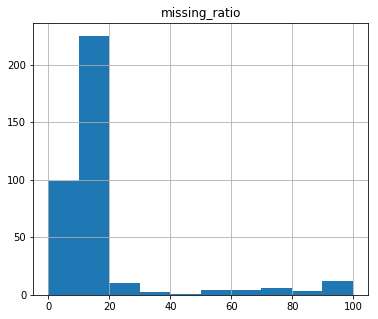

In [15]:
print(missing_ratio_df)

missing_ratio_df.hist(figsize=(6,5))


In [16]:

# get attributes with more than 20% missing nan
drop_attributes = missing_ratio_df.loc[missing_ratio_df['missing_ratio'] > 20]
list(drop_attributes.attribute)

clean_azdias_df = clean_azdias_df.drop(list(drop_attributes.attribute), axis=1)
clean_azdias_df.head()

# drop columns which have at least 80% non-nan values
clean_azdias_df.dropna(thresh=int(clean_azdias_df.shape[0]*0.8), axis=1)
clean_azdias_df.head()




,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [17]:
### Handle categorical data
cat_df = clean_azdias_df.select_dtypes(include=['object']).copy()

print(cat_df)


#CAMEO_DEU_2015	CAMEO_DEUG_2015	CAMEO_INTL_2015	EINGEFUEGT_AM	OST_WEST_KZ
print('CAMEO_DEU_2015: ', cat_df['CAMEO_DEU_2015'].value_counts().count()) # count the nbr of categories
print('CAMEO_DEUG_2015: ', cat_df['CAMEO_DEUG_2015'].value_counts().count())
print('CAMEO_INTL_2015: ', cat_df['CAMEO_INTL_2015'].value_counts().count())
print('OST_WEST_KZ: ', cat_df['OST_WEST_KZ'].value_counts().count())


       CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015        EINGEFUEGT_AM  \
0                 NaN             NaN             NaN                  NaN   
1                  8A               8              51  1992-02-10 00:00:00   
2                  4C               4              24  1992-02-12 00:00:00   
3                  2A               2              12  1997-04-21 00:00:00   
4                  6B               6              43  1992-02-12 00:00:00   
5                  8C               8              54  1992-02-12 00:00:00   
6                  4A               4              22  1992-02-12 00:00:00   
7                  2D               2              14  1992-02-10 00:00:00   
8                  1A               1              13  1992-02-10 00:00:00   
9                  1E               1              15  1992-02-10 00:00:00   
10                 9D               9              51  1992-02-10 00:00:00   
11                NaN             NaN             NaN           

In [18]:
# Transform OST_WEST_KZ 
#cat_df['OST_WEST_KZ'] = cat_df['OST_WEST_KZ'].map(lambda x: 0 if x=='W' else 1 )
# Only drop columns which have at least 90% non-NaNs
#df.dropna(thresh=int(df.shape[0] * .9), axis=1)

def parse_values(x):
    if isinstance(x, str):
        if x=='W':
            return int(0)
        else:
            return int(1)
    else:
        return x

clean_azdias_df['OST_WEST_KZ'] = clean_azdias_df['OST_WEST_KZ'].apply(parse_values)

print('OST_WEST_KZ is nan sum: ', round(clean_azdias_df['OST_WEST_KZ'].isna().sum()/clean_azdias_df['OST_WEST_KZ'].shape[0]*100, 2))
print('OST_WEST_KZ: ', clean_azdias_df['OST_WEST_KZ'].value_counts())
print('OST_WEST_KZ unique values: ', clean_azdias_df['OST_WEST_KZ'].unique())
#cat_df
                                                    

OST_WEST_KZ is nan sum:  10.45
OST_WEST_KZ:  0.0    629528
1.0    168545
Name: OST_WEST_KZ, dtype: int64
OST_WEST_KZ unique values:  [ nan   0.   1.]


In [19]:
# handle CAMEO_DEU_2015 - to be dropped too general 
print('CAMEO_DEU_2015 unique: ', cat_df['CAMEO_DEU_2015'].unique())
print('CAMEO_DEU_2015 value counts: ', cat_df['CAMEO_DEU_2015'].value_counts().unique())
print('CAMEO_DEU_2015 unique count: ', cat_df['CAMEO_DEU_2015'].value_counts().count())
print('CAMEO_DEU_2015 is nan sum: ', round(cat_df['CAMEO_DEU_2015'].isna().sum()/cat_df['CAMEO_DEU_2015'].shape[0]*100, 2))
print('CAMEO_DEU_2015 isnan count: ', cat_df['CAMEO_DEU_2015'].isna().sum())
cat_df['CAMEO_DEU_2015'].head()

CAMEO_DEU_2015 unique:  [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'
 'XX']
CAMEO_DEU_2015 value counts:  [56672 52438 47819 35074 34769 34399 34307 33434 33155 30993 28593 27676
 24987 24503 20542 19422 17576 16107 15486 14943 14820 13249 12214 11909
 10850 10543 10354  9935  9065  9047  8570  7160  6810  6379  6073  5392
  5333  5321  5065  4633  4317  4283  4071  3581   373]
CAMEO_DEU_2015 unique count:  45
CAMEO_DEU_2015 is nan sum:  11.11
CAMEO_DEU_2015 isnan count:  98979


0    NaN
1     8A
2     4C
3     2A
4     6B
Name: CAMEO_DEU_2015, dtype: object

In [20]:
def parse_values_CAMEO_DEUG_2015(x):
    if isinstance(x, str):
        if x=='X':
            return np.nan
        else:
            return int(x)
    return x

# handle CAMEO_DEUG_2015
clean_azdias_df['CAMEO_DEUG_2015'] = clean_azdias_df['CAMEO_DEUG_2015'].apply(parse_values_CAMEO_DEUG_2015)
print('CAMEO_DEUG_2015 unique: ', clean_azdias_df['CAMEO_DEUG_2015'].unique())
print('CAMEO_DEUG_2015 unique: ', clean_azdias_df['CAMEO_DEUG_2015'].value_counts().unique())
print('CAMEO_DEUG_2015 unique count: ', clean_azdias_df['CAMEO_DEUG_2015'].value_counts().count())
print('CAMEO_DEU_2015 isnan sum: ', round(clean_azdias_df['CAMEO_DEUG_2015'].isna().sum()/clean_azdias_df['CAMEO_DEUG_2015'].shape[0]*100, 2))
print('CAMEO_DEU_2015 isnan sum: ', clean_azdias_df['CAMEO_DEUG_2015'].isna().sum())
clean_azdias_df['CAMEO_DEUG_2015'].head()



CAMEO_DEUG_2015 unique:  [ nan   8.   4.   2.   6.   1.   9.   5.   7.   3.]
CAMEO_DEUG_2015 unique:  [134441 108177 105874 103912  86779  83231  77933  55310  36212]
CAMEO_DEUG_2015 unique count:  9
CAMEO_DEU_2015 isnan sum:  11.15
CAMEO_DEU_2015 isnan sum:  99352


0    NaN
1    8.0
2    4.0
3    2.0
4    6.0
Name: CAMEO_DEUG_2015, dtype: float64

In [21]:
def parse_values_CAMEO_INTL_2015(x):
    if isinstance(x, str):
        if x=='XX':
            return np.nan
        else:
            return int(x)
    return x

# handle CAMEO_INTL_2015 - similar to CAMEO_DEUG_2015 - rich /class index 
clean_azdias_df['CAMEO_INTL_2015'] = clean_azdias_df['CAMEO_INTL_2015'].apply(parse_values_CAMEO_INTL_2015)

print('CAMEO_INTL_2015 unique: ', clean_azdias_df['CAMEO_INTL_2015'].unique())
print('CAMEO_INTL_2015 unique: ', clean_azdias_df['CAMEO_INTL_2015'].value_counts().unique())
print('CAMEO_INTL_2015 unique count: ', clean_azdias_df['CAMEO_INTL_2015'].value_counts().count())
print('CAMEO_INTL_2015 isnan sum: ', round(clean_azdias_df['CAMEO_INTL_2015'].isna().sum()/clean_azdias_df['CAMEO_INTL_2015'].shape[0]*100, 2))
print('CAMEO_INTL_2015 isnan sum: ', clean_azdias_df['CAMEO_INTL_2015'].isna().sum())
clean_azdias_df['CAMEO_INTL_2015'].head()



CAMEO_INTL_2015 unique:  [ nan  51.  24.  12.  43.  54.  22.  14.  13.  15.  33.  41.  34.  55.  25.
  23.  31.  52.  35.  45.  44.  32.]
CAMEO_INTL_2015 unique:  [133694  92336  91158  62884  56672  45391  39628  33155  26750  26336
  26132  23955  20542  19024  18524  16974  14820  13249  10356  10354
   9935]
CAMEO_INTL_2015 unique count:  21
CAMEO_INTL_2015 isnan sum:  11.15
CAMEO_INTL_2015 isnan sum:  99352


0     NaN
1    51.0
2    24.0
3    12.0
4    43.0
Name: CAMEO_INTL_2015, dtype: float64

In [22]:
##handle mixed data - EINGEFUEGT_AM

print('EINGEFUEGT_AM unique: ', cat_df['EINGEFUEGT_AM'].unique())
print('EINGEFUEGT_AM unique: ', cat_df['EINGEFUEGT_AM'].value_counts().unique())
print('EINGEFUEGT_AM unique count: ', cat_df['EINGEFUEGT_AM'].value_counts().count())
print('EINGEFUEGT_AM isnan sum: ', round(cat_df['EINGEFUEGT_AM'].isna().sum()/cat_df['EINGEFUEGT_AM'].shape[0]*100, 2))
print('EINGEFUEGT_AM isnan sum: ', cat_df['EINGEFUEGT_AM'].isna().sum())
cat_df['EINGEFUEGT_AM'].head()

EINGEFUEGT_AM unique:  [nan '1992-02-10 00:00:00' '1992-02-12 00:00:00' ..., '2010-12-02 00:00:00'
 '2005-03-19 00:00:00' '2011-11-18 00:00:00']
EINGEFUEGT_AM unique:  [383738 192264  11181   6291   6050   3204   2343   2327   2290   2078
   2074   2032   2022   1944   1819   1484   1298   1292   1171   1151
   1139   1117   1116   1093   1051   1046   1021   1005    988    953
    889    871    833    816    815    799    780    731    699    694
    682    675    669    633    628    627    607    576    564    560
    554    548    546    544    542    533    531    525    514    510
    508    504    503    493    483    476    469    466    461    457
    456    453    450    440    439    435    428    425    424    423
    409    407    406    403    402    397    393    386    381    376
    375    368    362    358    356    352    350    346    344    343
    338    337    334    333    332    328    327    325    324    321
    318    317    316    315    314    313    312  

0                    NaN
1    1992-02-10 00:00:00
2    1992-02-12 00:00:00
3    1997-04-21 00:00:00
4    1992-02-12 00:00:00
Name: EINGEFUEGT_AM, dtype: object

In [23]:
# GEBURTSJAHR - DATE of birth
def parse_values_GEBURTSJAHR(x):
    if isinstance(x, int):
        if x==0:
            return np.nan
        else:
            return x
    return x

#cat_df['GEBURTSJAHR'] = clean_azdias_df['GEBURTSJAHR'].copy()
clean_azdias_df['GEBURTSJAHR'] = clean_azdias_df['GEBURTSJAHR'].apply(parse_values_GEBURTSJAHR)

print('GEBURTSJAHR unique: ', clean_azdias_df['GEBURTSJAHR'].unique())
print('GEBURTSJAHR unique: ', clean_azdias_df['GEBURTSJAHR'].value_counts().unique())
print('GEBURTSJAHR unique count: ', clean_azdias_df['GEBURTSJAHR'].value_counts().count())
print('GEBURTSJAHR isnan sum: ', round(clean_azdias_df['GEBURTSJAHR'].isna().sum()/clean_azdias_df['GEBURTSJAHR'].shape[0]*100, 2))
print('GEBURTSJAHR isnan sum: ', clean_azdias_df['GEBURTSJAHR'].isna().sum())
clean_azdias_df['GEBURTSJAHR'].head()

GEBURTSJAHR unique:  [   nan  1996.  1979.  1957.  1963.  1943.  1964.  1974.  1975.  1941.
  1993.  1946.  1988.  1991.  1966.  1949.  1982.  1972.  1990.  1985.
  1989.  1948.  1935.  1997.  1994.  1987.  2002.  1950.  1965.  1969.
  1978.  1958.  1944.  1967.  1977.  1960.  1970.  1973.  1971.  1937.
  1947.  1926.  1954.  1981.  1962.  1992.  2008.  1976.  1928.  1927.
  1968.  1940.  1952.  1961.  2006.  1938.  1945.  1942.  1984.  1930.
  1980.  1959.  1986.  1931.  1955.  1983.  2010.  1951.  1921.  1929.
  1939.  2001.  1995.  1956.  1953.  2012.  1934.  1913.  1914.  1922.
  2004.  1936.  2009.  1915.  2003.  2013.  1998.  2007.  1932.  2005.
  1923.  1925.  2015.  1933.  2017.  2000.  1999.  2014.  1920.  1918.
  1924.  2016.  2011.  1908.  1919.  1916.  1917.  1912.  1911.  1909.
  1910.  1904.  1906.  1905.  1900.  1907.  1902.]
GEBURTSJAHR unique:  [11183 11090 10933 10883 10799 10792 10513 10360 10275 10082  9880  9786
  9516  9509  9492  9422  9374  9296  9098  9027  900

0       NaN
1    1996.0
2    1979.0
3    1957.0
4    1963.0
Name: GEBURTSJAHR, dtype: float64

In [24]:
# KBA13_ANZAHL_PKW - number of cars in the PLZ8
def parse_values_KBA13_ANZAHL_PKW(x):
    if isinstance(x, int):
        if x==0:
            return np.nan
        else:
            return x
    return x

#cat_df['PLZ8_BAUMAX'] = clean_azdias_df['PLZ8_BAUMAX'].copy()
#cat_df['KBA13_ANZAHL_PKW'] = cat_df['KBA13_ANZAHL_PKW'].apply(parse_values_GEBURTSJAHR)

#print('KBA13_ANZAHL_PKW unique: ', cat_df['PLZ8_BAUMAX'].dropna().values)
#print('KBA13_ANZAHL_PKW unique: ', cat_df['PLZ8_BAUMAX'].value_counts().unique())
#print('KBA13_ANZAHL_PKW unique count: ', cat_df['PLZ8_BAUMAX'].value_counts().count())
#print('KBA13_ANZAHL_PKW isnan sum: ', round(cat_df['PLZ8_BAUMAX'].isna().sum()/cat_df['PLZ8_BAUMAX'].shape[0]*100, 2))
#print('KBA13_ANZAHL_PKW isnan sum: ', cat_df['PLZ8_BAUMAX'].isna().sum())
#cat_df['PLZ8_BAUMAX'].head()

In [25]:
# Remove similar features

# Suffix _FEIN - fine-grained information and suffix _GROB indicates coarse_grained information
drop_features = ['LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_GROB'] 

attributes_to_drop = ['LNR', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM', 'GEBURTSJAHR', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_GROB']
data_types = clean_azdias_df.dtypes
data_types



#clean_azdias_df[['ANZ_KINDER', 'CAMEO_DEUG_2015', 'HEALTH_TYP', 'FINANZTYP', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN',
#                'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'EINGEFUEGT_AM']].head()

# EINGEFUEGT_AM -  insertion timestamp - not very suitable for this analysis
# LNR -unique identifier
# GEBURTSJAHR - too many nan values
# CAMEO_DEU_2015 - very similar to CAMEO_DEUG_2015 -drop for similarity

#clean_azdias_df[['ANZ_KINDER', 'CAMEO_DEUG_2015', 'HEALTH_TYP', 'FINANZTYP', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN',
#                    'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'EINGEFUEGT_AM']].head()

LNR                             int64
AKT_DAT_KL                    float64
ANZ_HAUSHALTE_AKTIV           float64
ANZ_HH_TITEL                  float64
ANZ_KINDER                    float64
ANZ_PERSONEN                  float64
ANZ_STATISTISCHE_HAUSHALTE    float64
ANZ_TITEL                     float64
ARBEIT                        float64
BALLRAUM                      float64
CAMEO_DEU_2015                 object
CAMEO_DEUG_2015               float64
CAMEO_INTL_2015               float64
CJT_GESAMTTYP                 float64
CJT_KATALOGNUTZER             float64
CJT_TYP_1                     float64
CJT_TYP_2                     float64
CJT_TYP_3                     float64
CJT_TYP_4                     float64
CJT_TYP_5                     float64
CJT_TYP_6                     float64
D19_BANKEN_DIREKT               int64
D19_BANKEN_GROSS                int64
D19_BANKEN_LOKAL                int64
D19_BANKEN_REST                 int64
D19_BEKLEIDUNG_GEH              int64
D19_BEKLEIDU

Text(0,0.5,'number of rows')

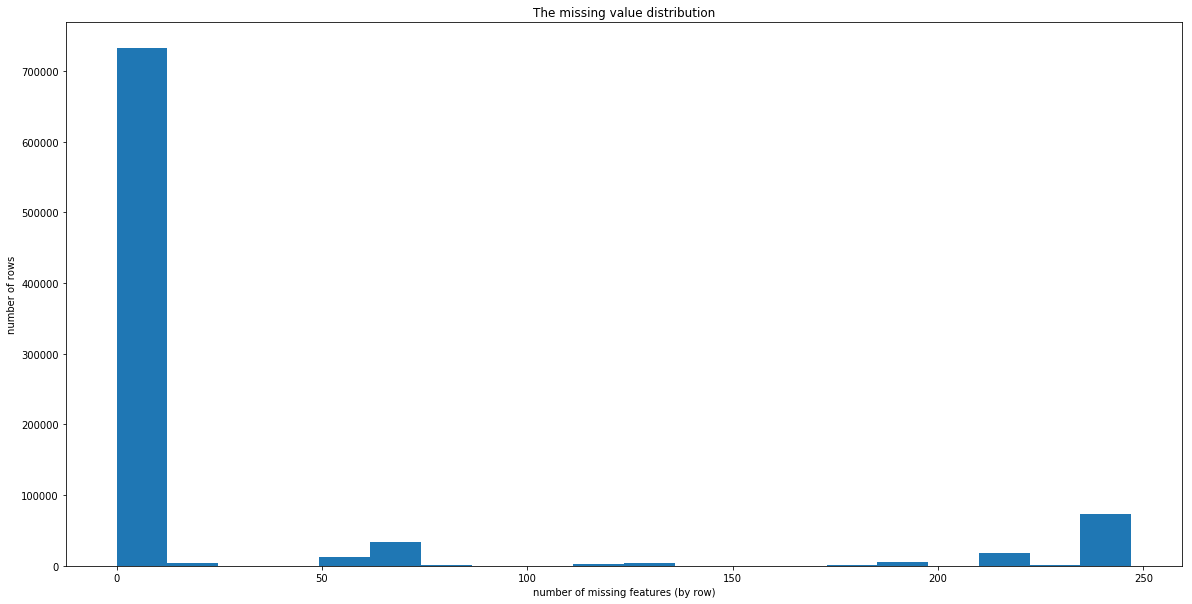

In [26]:
#handle nan on rows
#clean_azdias_df.isna().sum(axis=1)

plt.figure(figsize=(20, 10))
plt.hist(len(clean_azdias_df.columns) - clean_azdias_df.count(axis=1), bins=20)
plt.title('The missing value distribution')
plt.xlabel('number of missing features (by row)')
plt.ylabel('number of rows')



## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [27]:

clean_reduced_azdias_df = clean_azdias_df.copy()

In [28]:
# Delete rows which contains less than 240 non NaN values
print(clean_reduced_azdias_df.shape) #891221 rows

clean_reduced_azdias_df = clean_reduced_azdias_df.dropna(thresh=240)
clean_reduced_azdias_df.shape # 785421 ~ 11.9% reduced

(891221, 324)


(785209, 324)

In [29]:
numeric_features = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 'MIN_GEBAEUDEJAHR'] 


clean_reduced_azdias_df[numeric_features]
## There are many nan values in rows where the above features have nan values

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,MIN_GEBAEUDEJAHR
1,11.0,0.0,2.0,0.0,1996.0,1992.0
2,10.0,0.0,1.0,0.0,1979.0,1992.0
3,1.0,0.0,0.0,0.0,1957.0,1997.0
4,3.0,0.0,4.0,0.0,1963.0,1992.0
5,5.0,0.0,1.0,0.0,1943.0,1992.0
6,4.0,0.0,1.0,0.0,NaN,1992.0
7,6.0,0.0,1.0,0.0,1964.0,1992.0
8,2.0,1.0,1.0,0.0,1974.0,1992.0
9,9.0,0.0,1.0,0.0,1975.0,1992.0
10,6.0,0.0,1.0,0.0,1941.0,1992.0


In [30]:
# I use list of all values instead of unique values to fill nans, that would reflect the popularity of each value
# a high frequent value has higher change to be filled for a nan value
def fill_with_random(df):
    '''Fill `df2`'s column with name `column` with random data based on non-NaN data from `column`'''
    #df = df2.copy()
    
    for col in df.columns:    
        #df[col] = df[col].apply(lambda x: np.random.choice(df[col].dropna().values) if np.isnan(x) else x)
        df = random_choice(df, col)
        
    return df

def set_nan_value(x, values):
    random = np.random.choice(values)
    if np.isnan(x):
        #print('isnan set to: ', random, x)
        return random
    else:
        return x

def random_choice(df, col):
    values = df[col].dropna().values
    print(col)
    df[col] = df[col].apply(lambda x: set_nan_value(x, values))
    return df

In [31]:
# Dealing with NaNs
# Therefore, I choose the strategy to impute binary data with most frequent value, 
# numerical data with median value in the column. 
# Categorical missing values will be assigned to zeros after transformation to dummy columns. 
clean_reduced_azdias_df_no_nan = clean_reduced_azdias_df.copy()


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

def correlation_heatmap(df):
    correlations = df.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();

In [33]:
#correlation_heatmap(clean_reduced_azdias_df_no_nan)

In [34]:
def transform_value_to_wealth_index(x):
    wealthy = (11, 12, 13, 14, 15)
    prosperous = (21, 22, 23, 24, 25)
    comfortable = (31, 32, 33, 34, 35)
    less_affluent = (41, 42, 43, 44, 45)
    poorer = (51, 52, 53, 54, 55)
    
    lookup = {wealthy: 1, prosperous: 2, comfortable: 3, less_affluent: 4, poorer: 5}
    
    for wealth in lookup.keys():
        if (x in wealth):
            return lookup[wealth]

def transform_value_to_life_stage(x):
    pre_family = (11, 21, 31, 41, 51)
    young_couples_with_children = (12, 22, 32, 42, 51)
    families_with_school_age_children = (13, 23, 33, 43, 53)
    older_families = (14, 24, 34, 44, 54)
    elders_in_retirement = (15, 25, 35, 45, 55)
    
    lookup = {pre_family: 1, young_couples_with_children: 2, families_with_school_age_children: 3, older_families: 4, elders_in_retirement: 5}
    
    for key in lookup.keys():
        if (x in key):
            return lookup[key]

def transform_CAMEO_DEUINTL_2015(df):
    df['WEALTH_INDEX'] = df['CAMEO_INTL_2015'].apply(transform_value_to_wealth_index)    
    df['LIFE_STAGE_INDEX'] = df['CAMEO_INTL_2015'].apply(transform_value_to_life_stage)
    return df


In [35]:
clean_reduced_azdias_df_no_nan = transform_CAMEO_DEUINTL_2015(clean_reduced_azdias_df_no_nan)

In [36]:
# PRAEGENDE_JUGENDJAHRE
def transform_PRAEGENDE_JUGENDJAHRE_movement(x):
    maintream = (1, 3, 5, 8, 10, 12, 14)
    avantgarde = (2, 4, 7, 9, 11, 13, 15)
    
    lookup = {maintream: 0, avantgarde: 1}
    
    for movement in lookup.keys():
        if x in movement:
            return lookup[movement]

def transform_PRAEGENDE_JUGENDJAHRE_decade(x):
    forties = (1, 2)
    fifties = (3, 4)
    sixties = (5, 6, 7)
    seventies = (8, 9)
    eighties = (10, 11, 12, 13)
    nineties = (14, 15)
    
    lookup = {forties: 1, fifties: 2, sixties: 3, seventies: 4, eighties: 5, nineties: 6}
    
    for decades in lookup.keys():
        if x in decades:
            return lookup[decades]

def transform_PRAEGENDE_JUGENDJAHRE(df):
    df['DECADES'] = df['PRAEGENDE_JUGENDJAHRE'].apply(transform_PRAEGENDE_JUGENDJAHRE_decade)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(transform_PRAEGENDE_JUGENDJAHRE_movement)
    
    return df

In [37]:
clean_reduced_azdias_df_no_nan = transform_PRAEGENDE_JUGENDJAHRE(clean_reduced_azdias_df_no_nan)

In [38]:
# PLZ8_BAUMAX

def transform_PLZ8_BAUMAX_homes(x):
    homes = (1, 2, 3, 4)
    
    if x in homes:
        return x
    else:
        return 0

    
def transform_PLZ8_BAUMAX_business(x):
    homes = (1, 2, 3, 4)
    
    if x in homes:
        return 0
    else:
        return 1

def transform_PLZ8_BAUMAX(df):
    df['PLZ8_BAUMAX_HOMES'] = df['PLZ8_BAUMAX'].apply(transform_PLZ8_BAUMAX_homes)
    df['PLZ8_BAUMAX_BUSINESS'] = df['PLZ8_BAUMAX'].apply(transform_PLZ8_BAUMAX_business)
    
    return df

In [39]:
clean_reduced_azdias_df_no_nan = transform_PLZ8_BAUMAX(clean_reduced_azdias_df_no_nan)

In [40]:
attributes_to_drop = ['LNR', 'CAMEO_DEU_2015','EINGEFUEGT_AM', 'GEBURTSJAHR', 
                      'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB',
                      'CAMEO_INTL_2015', 'PLZ8_BAUMAX', 'PRAEGENDE_JUGENDJAHRE']

# 'LP_LEBENSPHASE_GROB' & 'LP_LEBENSPHASE_FEIN' indicate lifestage and income of a person which is done in 'CAMEO_INTL_2015'
# so I drop these 2 columns

# 'CAMEO_INTL_2015', 'PLZ8_BAUMAX', 'PRAEGENDE_JUGENDJAHRE' are dropped because they have been transformed 

clean_reduced_azdias_df_no_nan = clean_reduced_azdias_df_no_nan.drop(attributes_to_drop, axis=1)
#clean_reduced_azdias_df_no_nan['CAMEO_DEU_2015']

In [41]:
clean_azdias = fill_with_random(clean_reduced_azdias_df_no_nan)

#clean_reduced_azdias_df_no_nan['CAMEO_INTL_2015'].unique()
#clean_azdias = random_choice(clean_reduced_azdias_df_no_nan, 'CAMEO_DEUG_2015')



AKT_DAT_KL
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL


KeyboardInterrupt: 

In [ ]:
#correlation_heatmap

In [ ]:
#clean_azdias = fill_with_random(clean_reduced_azdias_df_no_nan)

#clean_azdias['CAMEO_INTL_2015'].unique()
#clean_azdias = random_choice(clean_reduced_azdias_df_no_nan, 'CAMEO_DEUG_2015')



In [ ]:
#asd = clean_reduced_azdias_df_no_nan['ANZ_HAUSHALTE_AKTIV'] + clean_reduced_azdias_df['ANZ_HAUSHALTE_AKTIV']
#df_new = pd.concat([clean_reduced_azdias_df_no_nan['KBA05_MAXVORB'], clean_reduced_azdias_df['KBA05_MAXVORB']], axis=1)
#df_new

In [ ]:
# missing ratio again for clean dataset
clean_missing_ratio_df = get_missing_ratio(clean_azdias)
print(clean_missing_ratio_df)

In [ ]:
# Standardization
#Then standardization procedure was used to scale features. 
# The advantage of standardization procedure that it does not bound values to a specific range 
# and it is much less affected by outliers.
# Normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

normalized_azdias_df = pd.DataFrame(scaler.fit_transform(clean_azdias.astype(float)))



In [ ]:

normalized_azdias_df.columns = clean_azdias.columns
normalized_azdias_df.index = clean_azdias.index

In [ ]:
normalized_azdias_df.head()

## Customer Segmentation


# Priciple Component Analysis (PCA)
Helps us reduce the number of features within the datasets. 

In [ ]:
#import sagemaker
#from sagemaker import get_execution_role

#session = sagemaker.get_Session()
#role = get_execution_role()
#print(role)

#bucket_name = session.default_bucket()
#print(bucket_name)






In [ ]:

# Define output_path to save the model training data

#prefix='azdias'

#output_path = 's3://{}/{}'.format(bucket_name, prefix)
#print('Training artifacts will be uploaded to {}'.format(output_path))
# Current feature -1 
#N_COMPONENTS = 318

#pca_SM = PCA(role=role,
#             train_instance_count=1,
#             train_instance_type='ml.c4.xlarge',
#             output_path=output_path,
#             num_components=N_COMPONENTS,
#             sagemaker_session=session)


In [ ]:
# Define a PCA model

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X=normalized_azdias_df)

# Conver Data into a RecordSet format 
Prepare the data for the built-in model by converting the dataframe to numpy array of float values

In [ ]:
#Convert to np array
train_data_np = normalized_azdias_df.values.astype('float32')


# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

# Train the data
Call the fit function on PCA model, passing in the formatted train data. This spins up a training instance to perform the training job


In [ ]:
%%time

pca_SM.fit(formatted_train_data)

# Accessing PCA model attributes


In [ ]:
training_job_name = ''

model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')

#download & unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

os.system('tar -zxvf model.tar.gz')
os.system('unzip model_azdias-1')


In [ ]:
import mxnet as mx

pca_model_params = mx.ndarray.load('model_azdias-1')

print(pca_model_params)

In [ ]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [ ]:
# Looking at top 5 components
n_principal_components = 5
start_idx = N_COMPONENTS - n_principal_components

print(s.iloc[start_idx]:, :) # last 5 

### EXERCISE: Calculate the explained variance

In creating new training data, you'll want to choose the top n principal components that account for at least 80% data variance. 

Complete a function, `explained_variance` that takes in the entire array `s` and a number of top principal components to consider. Then return the approximate, explained variance for those top n components. 

For example, to calculate the explained variance for the top 5 components, calculate s squared for *each* of the top 5 components, add those up and normalize by the sum of *all* squared s values, according to this formula:

\begin{equation*}
\frac{\sum_{5}^{ } s_n^2}{\sum s^2}
\end{equation*}

> Using this function, you should be able to answer the **question**: What is the smallest number of principal components that captures at least 80% of the total variance in the dataset?

In [ ]:
def explained_variance(s, n_top_components):
    start_idx = N_COMPONENTS - n_top_components
    # calculate appr variance
    exp_variance = np.square(s.iloc[start_idx:, :]).sum()/np.square(s).sum()
    
    return exp_variance[0]

In [ ]:
#test cell
n_top_components = 7
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

In [ ]:
#feature_list
feature_list = normalized_azdias_df.columns.values()
feature_list


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')